In [1]:
import os

In [2]:
import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader

# train model with smaller dataset
from torch.utils.data import Subset

from sklearn.model_selection import KFold

In [3]:
# GoogLeNet architecture mode
import torchvision.models as models
import torch.nn as nn

# Model optimization
import torch.optim as optim

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

### Set project directory

In [5]:
os.chdir("..")

In [6]:
# Define transformations (resizing and normalization)
image_size = (128, 128)

transform = transforms.Compose([
    transforms.Resize(image_size),  # Resize images
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [7]:
# data_folders = ['Baroque', 'Impressionism', 'Post_Impressionism', 
#                 'Abstract_Expressionism', 'Analytical_Cubism', 
#                 'Cubism', 'Synthetic_Cubism', 'Realism', 
#                 'New_Realism', 'Contemporary_Realism', 
#                 'Early_Renaissance', 'Mannerism_Late_Renaissance', 
#                 'Northern_Renaissance', 'High_Renaissance']

data_folders = ['Contemporary_Realism', 
                'Early_Renaissance',
                'Baroque', 'Impressionism', 'Post_Impressionism']

In [8]:
# Define dataset path
data_dir = "data"

# Get the full list of class names in the data directory
all_classes = os.listdir("data")
# Filter to include only selected classes
valid_classes = [cls for cls in all_classes if cls in data_folders]
# Create a mapping for selected classes
class_to_idx = {cls: i for i, cls in enumerate(valid_classes)}

# Load dataset
small_dataset = None # optional for faster model training with smaller dataset
dataset = datasets.ImageFolder(root=data_dir, transform=transform)

# Filter dataset to only keep selected classes
dataset.samples = [s for s in dataset.samples if s[1] in class_to_idx.values()]
dataset.targets = [class_to_idx[dataset.classes[i]] for i in dataset.targets if dataset.classes[i] in data_folders]
dataset.classes = valid_classes
dataset.class_to_idx = class_to_idx

### [Optional] Train model with smaller dataset (maximum images for each class)

In [9]:
# Define the maximum number of images per class
max_images_per_class = 500

In [10]:
# Create a filtered list of indices
selected_indices = []
class_counts = {cls: 0 for cls in dataset.class_to_idx.keys()}

for i in range(len(dataset)):
    _, label = dataset.samples[i]
    class_name = dataset.classes[label]
    
    if class_counts[class_name] < max_images_per_class:
        selected_indices.append(i)
        class_counts[class_name] += 1

# Create a subset dataset
small_dataset = Subset(dataset, selected_indices)

dataset = small_dataset

In [11]:
# Split into training and validation sets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

### Load Pretrained GoogLeNet Model

In [12]:
# # Load the pretrained GoogLeNet model
# model = models.googlenet(pretrained=False)

In [13]:
# # Modify the final fully connected layer
# num_classes = len(data_folders)
# model.fc = nn.Linear(model.fc.in_features, num_classes)

In [14]:
# # Move model to GPU if available
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = model.to(device)

### Define the model paramters

In [15]:
# model parameters

# Define parameters for k-fold
learning_rates = [0.001, 0.005, 0.01]
epochs_list = [3, 5, 10]
k_folds = 5  # Number of splits for cross-validation
batch_size = 8
num_workers = 0

In [16]:
# K-Fold Cross Validator
kfold = KFold(n_splits=k_folds, shuffle=True, random_state=42)

In [17]:
# Store results
train_accuracies = {}
val_accuracies = {}

train_losses = {}
val_losses = {}

### Training the model

In [21]:
# Get all predictions and actual labels
all_preds = []
all_labels = []

# Loop through hyperparameter combinations
for lr in learning_rates:
    for num_epochs in epochs_list:
        fold_train_accuracies = []
        fold_train_losses = []
        
        fold_val_accuracies = []
        fold_val_losses = []

        print(f"\nTesting: Learning Rate = {lr}, Epochs = {num_epochs}")

        # Cross-validation loop
        for fold, (train_idx, val_idx) in enumerate(kfold.split(dataset)):
            print(f"Fold {fold+1}/{k_folds}")

            # Create train and validation subsets
            train_subsampler = Subset(dataset, train_idx)
            val_subsampler = Subset(dataset, val_idx)

            # Create DataLoaders
            train_loader = DataLoader(train_subsampler, batch_size=batch_size, shuffle=True, num_workers=0)
            val_loader = DataLoader(val_subsampler, batch_size=batch_size, shuffle=False, num_workers=0)

            # Define model
            model = models.googlenet(pretrained = True)
            num_classes = len(data_folders)
            model.fc = nn.Linear(model.fc.in_features, num_classes)
            # Move model to GPU if available
            device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
            model = model.to(device)

            # Loss and optimizer
            criterion = nn.CrossEntropyLoss()
            optimizer = optim.Adam(model.parameters(), lr=lr)

            # Training loop
            for epoch in range(num_epochs):
                model.train()
                running_loss = 0.0
                correct_train, total_train = 0, 0
                for images, labels in train_loader:
                    images, labels = images.to(device), labels.to(device)
                    
                    optimizer.zero_grad()
                    outputs = model(images)
                    loss = criterion(outputs, labels)
                    running_loss += loss.item()
                    loss.backward()
                    optimizer.step()

                    _, predicted = torch.max(outputs, 1)
                    total_train += labels.size(0)
                    correct_train += (predicted == labels).sum().item()


                fold_train_accuracy = 100 * correct_train / total_train
                fold_train_accuracies.append(fold_train_accuracy)

                fold_train_losses.append(running_loss / len(train_loader))
                    

            # Validation loop
            model.eval()
            val_loss = 0.0
            correct_val, total_val = 0, 0
            with torch.no_grad():
                for images, labels in val_loader:
                    images, labels = images.to(device), labels.to(device)
                    outputs = model(images)
                    _, predicted = torch.max(outputs, 1)
                    total_val += labels.size(0)
                    correct_val += (predicted == labels).sum().item()
                    val_loss += loss.item()

            fold_val_accuracy = 100 * correct_val / total_val
            fold_val_accuracies.append(fold_val_accuracy)

            fold_val_losses.append(val_loss / len(val_loader))

        # Store average accuracy for this hyperparameter set
        avg_train_accuracy = np.mean(fold_train_accuracies)
        train_accuracies[(lr, num_epochs)] = fold_train_accuracies
        avg_train_loss = np.mean(fold_train_losses)
        train_losses[(lr, num_epochs)] = fold_train_losses

        avg_val_accuracy = np.mean(fold_val_accuracies)
        val_accuracies[(lr, num_epochs)] = fold_val_accuracies
        avg_val_loss = np.mean(fold_val_losses)
        val_losses[(lr, num_epochs)] = fold_val_losses
        print(f"Avg Training Accuracy for LR={lr}, Epochs={num_epochs}: {avg_train_accuracy:.2f}%")
        print(f"Avg Validation Accuracy for LR={lr}, Epochs={num_epochs}: {avg_val_accuracy:.2f}%")
        print(f"Avg Training Loss for LR={lr}, Epochs={num_epochs}: {avg_train_loss:.2f}")
        print(f"Avg Validation Loss for LR={lr}, Epochs={num_epochs}: {avg_val_loss:.2f}")


Testing: Learning Rate = 0.001, Epochs = 3
Fold 1/5


c:\Users\naimi\anaconda3\envs\dads\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\naimi\anaconda3\envs\dads\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Fold 2/5
Fold 3/5
Fold 4/5
Fold 5/5
Avg Training Accuracy for LR=0.001, Epochs=3: 66.05%
Avg Validation Accuracy for LR=0.001, Epochs=3: 72.60%
Avg Training Loss for LR=0.001, Epochs=3: 0.91
Avg Validation Loss for LR=0.001, Epochs=3: 0.66

Testing: Learning Rate = 0.001, Epochs = 5
Fold 1/5
Fold 2/5
Fold 3/5
Fold 4/5
Fold 5/5
Avg Training Accuracy for LR=0.001, Epochs=5: 69.56%
Avg Validation Accuracy for LR=0.001, Epochs=5: 74.35%
Avg Training Loss for LR=0.001, Epochs=5: 0.82
Avg Validation Loss for LR=0.001, Epochs=5: 0.69

Testing: Learning Rate = 0.001, Epochs = 10
Fold 1/5
Fold 2/5
Fold 3/5
Fold 4/5
Fold 5/5
Avg Training Accuracy for LR=0.001, Epochs=10: 76.69%
Avg Validation Accuracy for LR=0.001, Epochs=10: 75.53%
Avg Training Loss for LR=0.001, Epochs=10: 0.64
Avg Validation Loss for LR=0.001, Epochs=10: 0.39

Testing: Learning Rate = 0.005, Epochs = 3
Fold 1/5
Fold 2/5
Fold 3/5
Fold 4/5
Fold 5/5
Avg Training Accuracy for LR=0.005, Epochs=3: 39.92%
Avg Validation Accuracy for

In [22]:
# # Find best hyperparameters
# best_params = max(val_accuracies, key=val_accuracies.get)
# print(f"\nBest Hyperparameters: Learning Rate = {best_params[0]}, Epochs = {best_params[1]}")

### Evaluate the model

dict_items([((0.001, 3), [79.53216374269006, 69.5906432748538, 70.46783625730994, 68.32844574780059, 75.0733137829912]), ((0.001, 5), [83.33333333333333, 77.48538011695906, 68.12865497076024, 66.56891495601172, 76.24633431085044]), ((0.001, 10), [75.43859649122807, 73.39181286549707, 78.94736842105263, 70.96774193548387, 78.88563049853373]), ((0.005, 3), [42.39766081871345, 44.15204678362573, 49.41520467836257, 29.618768328445746, 47.50733137829912]), ((0.005, 5), [39.1812865497076, 44.73684210526316, 42.10526315789474, 44.868035190615835, 41.935483870967744]), ((0.005, 10), [56.432748538011694, 50.292397660818715, 45.90643274853801, 47.800586510263926, 51.61290322580645]), ((0.01, 3), [49.41520467836257, 44.15204678362573, 45.32163742690059, 39.589442815249264, 43.988269794721404]), ((0.01, 5), [45.6140350877193, 42.69005847953216, 40.93567251461988, 47.800586510263926, 48.09384164222874]), ((0.01, 10), [49.707602339181285, 47.66081871345029, 52.92397660818713, 40.76246334310851, 47.8

ValueError: x and y must have same first dimension, but have shapes (1,) and (5,)

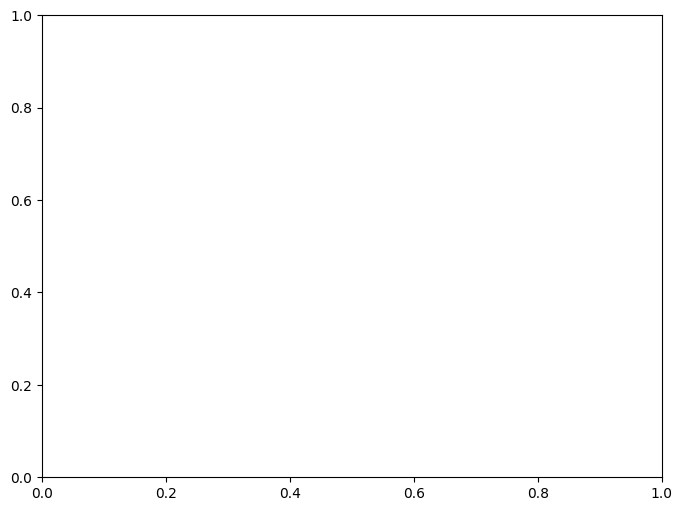

In [24]:
plt.figure(figsize=(8, 6))

print(val_accuracies.items())
# Plot each learning rate separately
for (lr, num_epochs), accuracies in val_accuracies.items():
    plt.plot(num_epochs, accuracies, label=f"LR={lr}")

plt.xlabel("Epochs")
plt.ylabel("Validation Accuracy (%)")
plt.title("Accuracy over Epochs for Different Learning Rates")
plt.legend()
plt.grid()
plt.show()

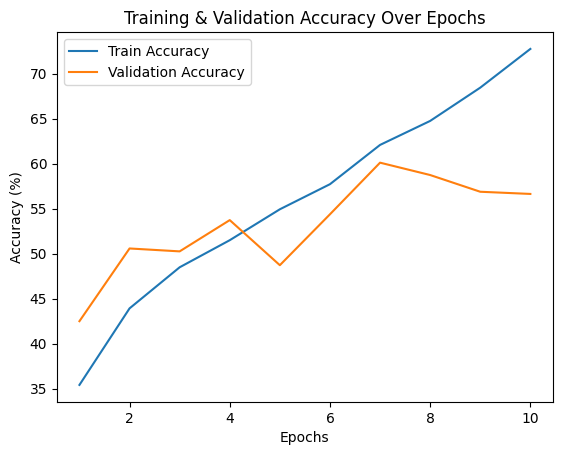

In [21]:
# # Plot Accuracy Curves
# plt.plot(range(1, num_epochs+1), train_accuracies, label="Train Accuracy")
# plt.plot(range(1, num_epochs+1), val_accuracies, label="Validation Accuracy")
# plt.xlabel("Epochs")
# plt.ylabel("Accuracy (%)")
# plt.title("Training & Validation Accuracy Over Epochs")
# plt.legend()
# plt.show()

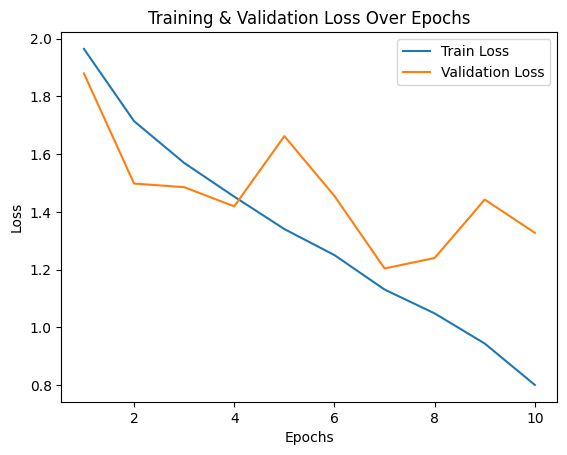

In [22]:
# # Plot Loss Curves
# plt.plot(range(1, num_epochs+1), train_losses, label="Train Loss")
# plt.plot(range(1, num_epochs+1), val_losses, label="Validation Loss")
# plt.xlabel("Epochs")
# plt.ylabel("Loss")
# plt.title("Training & Validation Loss Over Epochs")
# plt.legend()
# plt.show()

In [23]:
# # Compute Confusion Matrix
# cm = confusion_matrix(all_labels, all_preds)
# if small_dataset is not None:
#     class_names = dataset.dataset.classes
# else:
#     class_names = dataset.classes

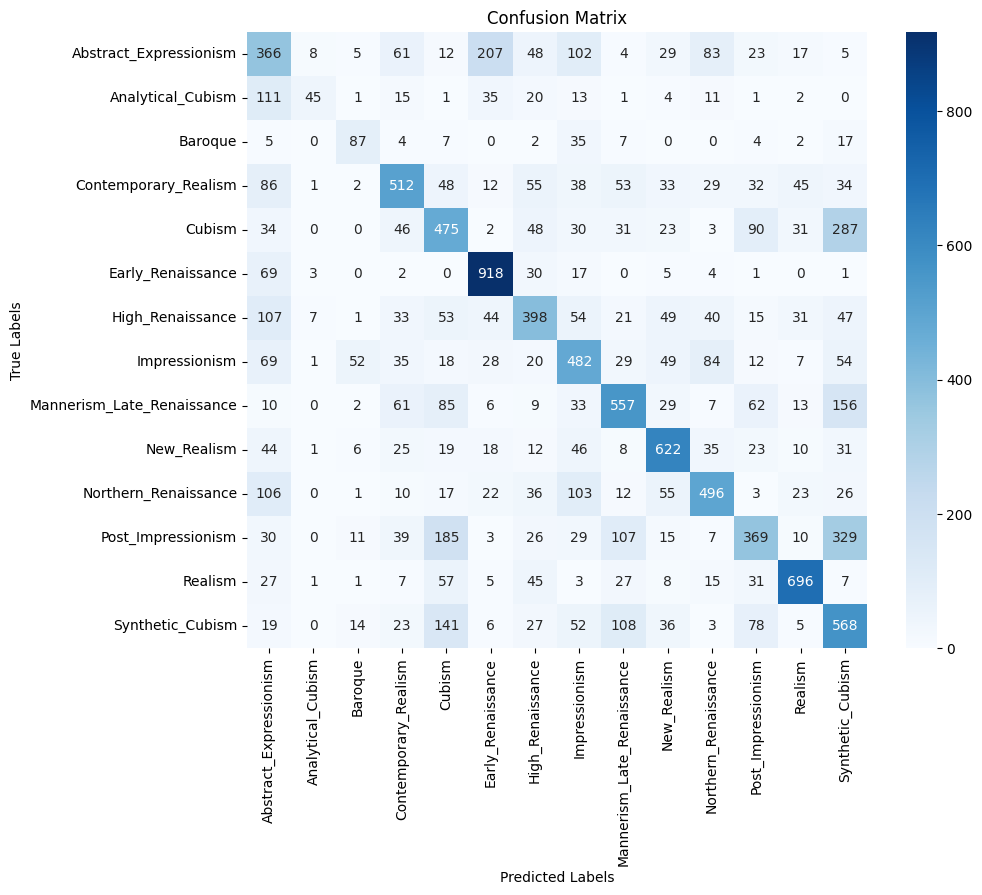

In [24]:
# # Plot
# plt.figure(figsize=(10, 8))
# sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
# plt.xlabel("Predicted Labels")
# plt.ylabel("True Labels")
# plt.title("Confusion Matrix")
# plt.show()